In [1]:
import torch
import torch.optim as optim
import numpy as np
import scanpy as sc
import scvelo as scv
from model import NETWORK  # Ensure that model.py is saved in the same directory
from dataloaders import setup_dataloaders  # Ensure that dataloaders.py is saved in the same directory
from utils import manifold_and_neighbors


# Setup configuration
latent_dim = 64  # Latent dimension size, can be adjusted
hidden_dim = 512  # Hidden dimension size for the encoder and decoder
batch_size = 256  # Batch size for training
epochs = 200  # Number of epochs for training
learning_rate = 1e-4  # Learning rate for the optimizer
lambda1 = 1  # Weight for heuristic loss
lambda2 = 1e-1  # Weight for discrepancy loss
K = 11  # Number of neighbors for heuristic loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

n_components = 10
n_knn_search = 10
dataset_name = "pancreas"
cell_type_key = "clusters"
knn_rep = "ve"
best_key = None
ve_layer = "None"

# Load data
adata = scv.datasets.pancreas()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=4000)
#adata = adata[adata.obs["stage"]=="E8.25"].copy()
scv.pp.moments(adata, n_neighbors=200)
Mu = adata.layers["Mu"]
Ms = adata.layers["Ms"]
adata.obsm["MuMs"] = np.concatenate([Mu, Ms], axis=1)
manifold_and_neighbors(adata, n_components, n_knn_search, dataset_name, K, knn_rep, best_key, ve_layer)
input_dim = adata.shape[1] * 2  # Assuming 2000 unspliced and 2000 spliced genes as input

# Initialize model, optimizer, and loss function
model = NETWORK(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up data loaders
train_loader, test_loader, full_data_loader = setup_dataloaders(adata, batch_size=batch_size, train_size=1, split_data=False)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for batch_idx, (inputs, batch_indices) in enumerate(train_loader):
        inputs = inputs.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        out_dic = model(inputs)
        
        # Compute loss
        losses_dic = model.heuristic_loss(
            adata=adata, 
            x=inputs, 
            batch_indices=batch_indices,
            lambda1=lambda1, 
            lambda2=lambda2, 
            out_dic=out_dic, 
            device=device,
            K=K
        )
        
        # Backward pass and optimization
        loss = losses_dic["total_loss"]
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for monitoring
        running_loss += loss.item()
        
        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}], Loss: {loss.item()}')
    
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss / len(train_loader)}')

    # Save the model periodically
    """if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')"""

# After training, save final model
torch.save(model.state_dict(), 'final_model.pth')
"""
# Test the model on the test set (if available)
if test_loader is not None:
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():
        for inputs, batch_indices in test_loader:
            inputs = inputs.to(device)
            out_dic = model(inputs)
            
            # Compute test loss
            losses_dic = model.heuristic_loss(
                adata=adata, 
                x=inputs, 
                batch_indices=batch_indices,
                lambda1=lambda1, 
                lambda2=lambda2, 
                out_dic=out_dic, 
                device=device,
                K=K
            )
            total_test_loss += losses_dic["total_loss"].item()

    print(f'Test Loss: {total_test_loss / len(test_loader)}')"""

# Initialize empty layers in adata for storing results
adata.layers["velocity_u"] = np.zeros_like(adata.layers["Mu"])  # Initialize for velocity_u
adata.layers["velocity"] = np.zeros_like(adata.layers["Ms"])  # Initialize for velocity (spliced)
adata.layers["pp"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["nn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["pn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["np"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.obsm["pred"] = np.zeros((adata.shape[0], adata.shape[1] * 2))  # Assuming 2*genes for prediction

# Fetch output dictionary for the entire dataset after training and store results in adata layers
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for inputs, batch_indices in full_data_loader:
        inputs = inputs.to(device)
        out_dic = model(inputs)

        # Store the results in adata layers according to batch_indices
        adata.layers["velocity_u"][batch_indices] = out_dic["v_u"].cpu().numpy()
        adata.layers["velocity"][batch_indices] = out_dic["v_s"].cpu().numpy()
        adata.layers["pp"][batch_indices] = out_dic["pp"].cpu().numpy()
        adata.layers["nn"][batch_indices] = out_dic["nn"].cpu().numpy()
        adata.layers["pn"][batch_indices] = out_dic["pn"].cpu().numpy()
        adata.layers["np"][batch_indices] = out_dic["np"].cpu().numpy()

        # Store predictions in adata.obsm
        adata.obsm["pred"][batch_indices] = out_dic["pred"].cpu().numpy()

print('Results stored in adata.layers and adata.obsm')


Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 4000 highly variable genes.
Logarithmized X.
computing neighbors


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing isomap 1...


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py:330: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  self.eigenvalues_, self.eigenvectors_ = linalg.eigh(


computing isomap 2..
ve shape: (3696, 64)
adata shape: (3696, 4000)
n_components: 10
n_neighbors: 10
knn rep used: ve
ve key used
Epoch [1/200], Batch [0], Loss: 0.998028039932251
Epoch [1/200], Batch [10], Loss: 0.7728049159049988
Epoch [1/200], Average Loss: 0.8463829596837361
Epoch [2/200], Batch [0], Loss: 0.7170814275741577
Epoch [2/200], Batch [10], Loss: 0.6552672982215881
Epoch [2/200], Average Loss: 0.6736908713976543
Epoch [3/200], Batch [0], Loss: 0.6293086409568787
Epoch [3/200], Batch [10], Loss: 0.5707976818084717
Epoch [3/200], Average Loss: 0.5769640247027079
Epoch [4/200], Batch [0], Loss: 0.5130146145820618
Epoch [4/200], Batch [10], Loss: 0.4515584409236908
Epoch [4/200], Average Loss: 0.470003080368042
Epoch [5/200], Batch [0], Loss: 0.4038996398448944
Epoch [5/200], Batch [10], Loss: 0.3966328799724579
Epoch [5/200], Average Loss: 0.38773462375005086
Epoch [6/200], Batch [0], Loss: 0.36145123839378357
Epoch [6/200], Batch [10], Loss: 0.2973957061767578
Epoch [6/200

computing velocity graph (using 1/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:55) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs

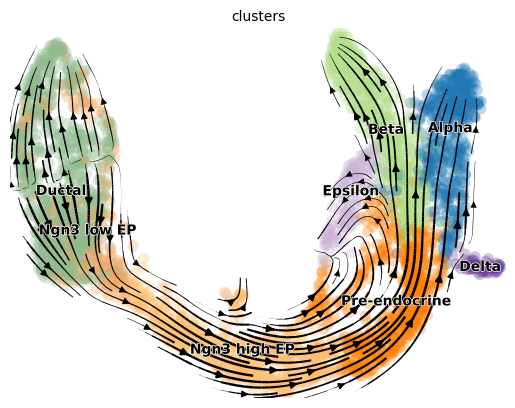

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


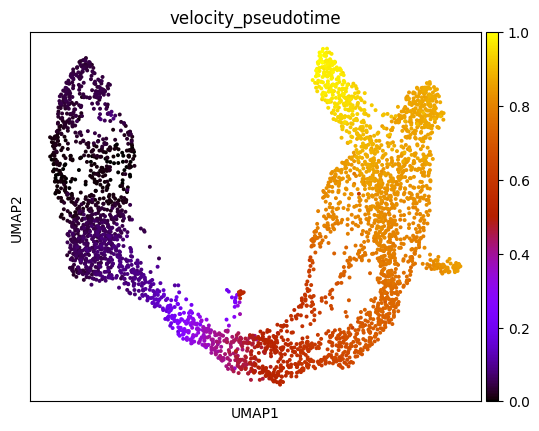

In [2]:
adata.layers["velocity"] *= -1
adata.layers["velocity_u"] *= -1

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=cell_type_key)
scv.tl.velocity_pseudotime(adata)
sc.pl.umap(adata, color="velocity_pseudotime", cmap="gnuplot")

In [3]:
import matplotlib.pyplot as plt

def plot_phase_plane(adata, gene_name, dataset, K, u_scale=.01, s_scale=0.01, alpha=0.5, head_width=0.02, head_length=0.03, length_includes_head=False, log=False,
                        norm_velocity=True, filter_cells=False, smooth_expr=True, show_plot=True, save_plot=True, save_path=".",
                        cell_type_key="clusters"):

    if smooth_expr:
        unspliced_expression = adata.layers["Mu"][:, adata.var_names.get_loc(gene_name)].flatten() 
        spliced_expression = adata.layers["Ms"][:, adata.var_names.get_loc(gene_name)].flatten() 
    else:
        unspliced_expression = adata.layers["unspliced"][:, adata.var_names.get_loc(gene_name)].flatten()
        spliced_expression = adata.layers["spliced"][:, adata.var_names.get_loc(gene_name)].flatten()

    # Normalize the expression data
    unspliced_expression_min, unspliced_expression_max = np.min(unspliced_expression), np.max(unspliced_expression)
    spliced_expression_min, spliced_expression_max = np.min(spliced_expression), np.max(spliced_expression)

    # Min-Max normalization
    unspliced_expression = (unspliced_expression - unspliced_expression_min) / (unspliced_expression_max - unspliced_expression_min)
    spliced_expression = (spliced_expression - spliced_expression_min) / (spliced_expression_max - spliced_expression_min)

    # Extract the velocity data
    unspliced_velocity = adata.layers['velocity_u'][:, adata.var_names.get_loc(gene_name)].flatten()
    spliced_velocity = adata.layers['velocity'][:, adata.var_names.get_loc(gene_name)].flatten()

    def custom_scale(data):
        max_abs_value = np.max(np.abs(data))  # Find the maximum absolute value
        scaled_data = data / max_abs_value  # Scale by the maximum absolute value
        return scaled_data

    if norm_velocity:
        unspliced_velocity = custom_scale(unspliced_velocity)
        spliced_velocity = custom_scale(spliced_velocity)


    # Apply any desired transformations (e.g., log) here
    if log:
        # Apply log transformation safely, ensuring no log(0)
        unspliced_velocity = np.log1p(unspliced_velocity)
        spliced_velocity = np.log1p(spliced_velocity)

    # Generate boolean masks for conditions and apply them
    if filter_cells:
        valid_idx = (unspliced_expression > 0) & (spliced_expression > 0)
    else:
        valid_idx = (unspliced_expression >= 0) & (spliced_expression >= 0)

    # Filter data based on valid_idx
    unspliced_expression_filtered = unspliced_expression[valid_idx]
    spliced_expression_filtered = spliced_expression[valid_idx]
    unspliced_velocity_filtered = unspliced_velocity[valid_idx]
    spliced_velocity_filtered = spliced_velocity[valid_idx]

    # Also filter cell type information to match the filtered expressions
    # First, get unique cell types and their corresponding colors
    unique_cell_types = adata.obs[cell_type_key].cat.categories
    celltype_colors = adata.uns[f"{cell_type_key}_colors"]
    
    # Create a mapping of cell type to its color
    celltype_to_color = dict(zip(unique_cell_types, celltype_colors))

    # Filter cell types from the data to get a list of colors for the filtered data points
    cell_types_filtered = adata.obs[cell_type_key][valid_idx]
    colors = cell_types_filtered.map(celltype_to_color).to_numpy()
    plt.figure(figsize=(9, 6.5), dpi=100)
  # Lower dpi here if the file is still too large    scatter = plt.scatter(unspliced_expression_filtered, spliced_expression_filtered, c=colors, alpha=0.6)

    """# Plot velocity vectors
    for i in range(len(unspliced_expression_filtered)):
        cell_type_index = np.where(unique_cell_types == cell_types_filtered[i])[0][0]
        arrow_color = celltype_to_color[cell_types_filtered[i]]  # Use the color corresponding to the cell type
        plt.arrow(
            unspliced_expression_filtered[i], spliced_expression_filtered[i], 
            unspliced_velocity_filtered[i] * u_scale, spliced_velocity_filtered[i] * s_scale, 
            color=arrow_color, alpha=alpha, head_width=head_width, head_length=head_length, length_includes_head=length_includes_head
        )"""

    # Plot velocity vectors
    for i in range(len(unspliced_expression_filtered)):
        cell_type_index = np.where(unique_cell_types == cell_types_filtered[i])[0][0]
        arrow_color = celltype_to_color[cell_types_filtered[i]]  # Use the color corresponding to the cell type
        plt.arrow(
            spliced_expression_filtered[i], unspliced_expression_filtered[i], 
            spliced_velocity_filtered[i] * s_scale, unspliced_velocity_filtered[i] * u_scale, 
            color=arrow_color, alpha=alpha, head_width=head_width, head_length=head_length, length_includes_head=length_includes_head
        )

    plt.ylabel(f'Normalized Unspliced Expression of {gene_name}')
    plt.xlabel(f'Normalized Spliced Expression of {gene_name}')
    plt.title(f'Expression and Velocity of {gene_name} by Cell Type')

    # Create a legend
    patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=celltype_to_color[celltype], markersize=10, label=celltype) 
            for celltype in unique_cell_types]
    plt.legend(handles=patches, title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

    

    if save_plot:
        plt.savefig(save_path, format='png', bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    # Check if show_plot is True, then display the plot
    if show_plot:
        plt.show()
    else:
        plt.close()

    plt.show()


In [4]:
list(adata.var_names)

['Sntg1',
 'Snhg6',
 'Arfgef1',
 'Ncoa2',
 'Lactb2',
 'Sbspon',
 'Stau2',
 'Ube2w',
 'Mcm3',
 'Fam135a',
 'Adgrb3',
 'Bag2',
 'Zfp451',
 'Uggt1',
 'Tmem131',
 '2010300C02Rik',
 'Rev1',
 'Tbc1d8',
 'Fhl2',
 'Tex30',
 'Slc39a10',
 'Myo1b',
 'Gls',
 'Nab1',
 'Mfsd6',
 'Pgap1',
 'Ankrd44',
 'Hspd1',
 'Clk1',
 'Orc2',
 'Fam126b',
 'Ino80d',
 'Klf7',
 'Akr1cl',
 'Idh1',
 'Acadl',
 'Lancl1',
 'Fn1',
 'Mreg',
 'Pecr',
 'March4',
 'Igfbp5',
 'Tmbim1',
 'Rnf25',
 'Fev',
 'Cryba2',
 'Cnppd1',
 'Ptprn',
 'Resp18',
 'Dnpep',
 'Epha4',
 'Wdfy1',
 'Serpine2',
 'Cul3',
 'Sphkap',
 'Dner',
 'Ngef',
 'Hjurp',
 'Per2',
 'Hdac4',
 'Kif1a',
 'Mterf4',
 'Dtymk',
 'Pam',
 'Rnf152',
 'Bcl2',
 'Vps4b',
 'Ptpn4',
 'Dbi',
 'Insig2',
 'Dpp10',
 'Actr3',
 'Tmem163',
 'Mcm6',
 'Srgap2',
 'Nfasc',
 'Sox13',
 'Atp2b4',
 'Btg2',
 'Tmem183a',
 'Ppp1r12b',
 'Nav1',
 'Camsap2',
 'Nr5a2',
 'Nek7',
 'Cdc73',
 'Trove2',
 'BC003331',
 'Gm10138',
 'Swt1',
 'Rgl1',
 'Lamc1',
 'Npl',
 'Xpr1',
 'Qsox1',
 'Cep350',
 'Fam163a',
 '

IsADirectoryError: [Errno 21] Is a directory: '.'

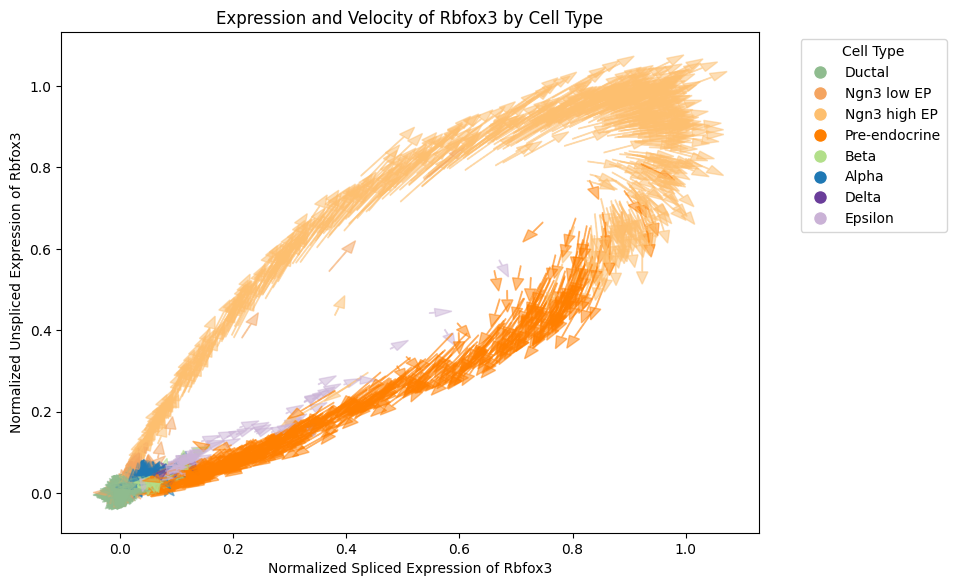

In [6]:
plot_phase_plane(adata, "Rbfox3", dataset_name, 11, u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key)

IsADirectoryError: [Errno 21] Is a directory: '.'

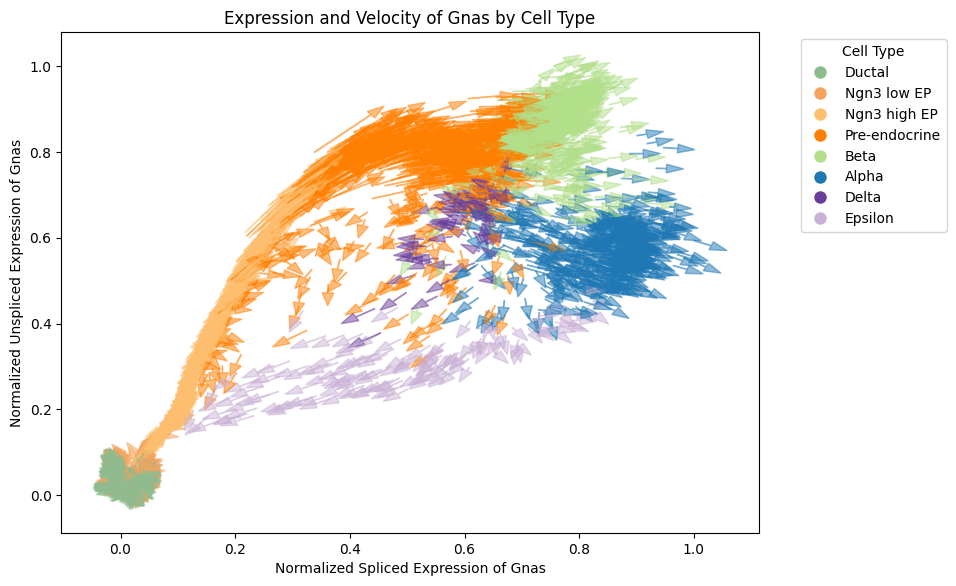

In [7]:
plot_phase_plane(adata, "Gnas", dataset_name, 11, u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key)

In [8]:
adata.write_h5ad("pancreas_goodresult.h5ad")